# Trabajo final de Ingeniería de atributos y modelos para el aprendizaje automático

Resumen:

En este trabajo se utiliza una red neuronal para un problema de clasificación binaria sobre imagenes.

Utilizando una red neuronal convulocional multicapa se detecta si las diferentes partes de la cabeza de un espermatozoide presentan una forma normal o anómala.

Las posibles formas anormales estudiadas son:  la cabeza, el acrosoma y la vacuola, clasificando cada una de la tres caracteristicas por separado.

El dataset se divide en 3: training (1000 imagenes), validacion(240) y test (300)

Las imagenes usadas son de 64x64 pixeles

Utilice el el dataset [mhsma](https://github.com/soroushj/mhsma-dataset) y me base en el [paper](https://drive.google.com/file/d/1y6P1lTHp3IwUm7AaoglgSF5cJnspPauU/view?usp=sharing)

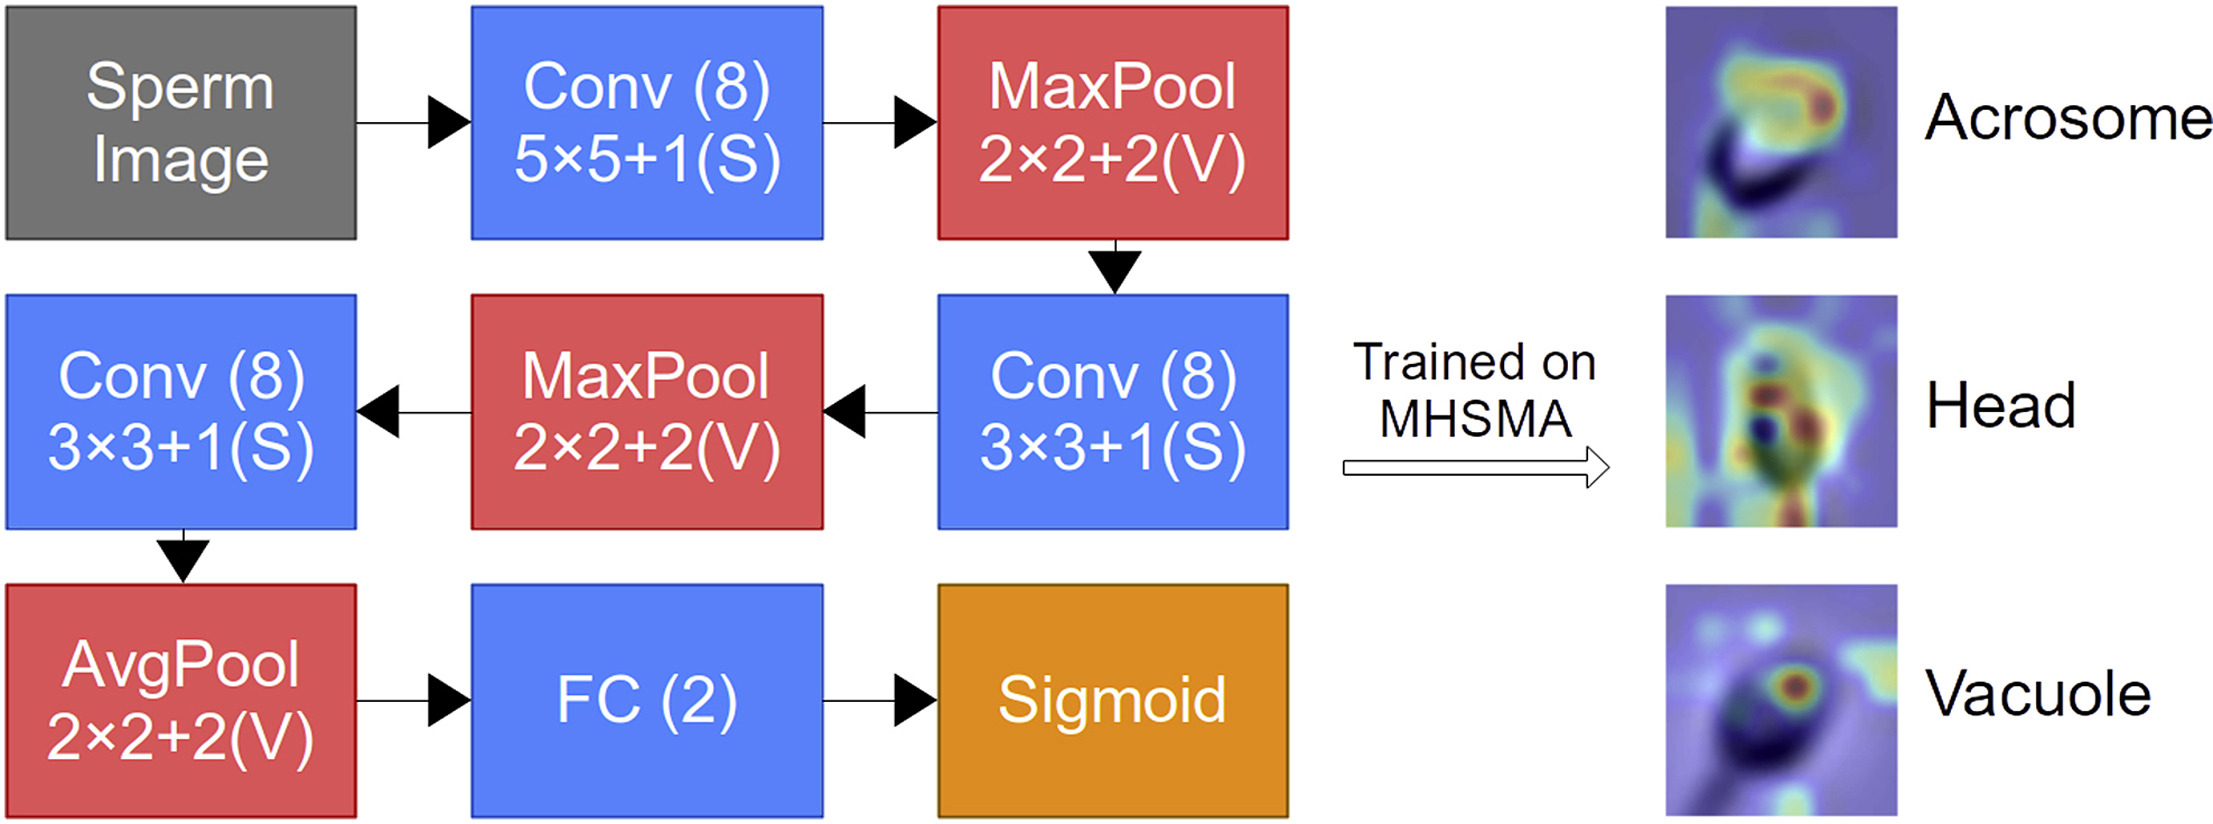



---

Importando las librerias utilizadas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

In [ ]:
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset,  TensorDataset, DataLoader, Subset, random_split
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
    confusion_matrix,
    fbeta_score,
    matthews_corrcoef
    )

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'



---



## Datos

Importación de los datos, cambio de formato y visualización

In [ ]:
!git clone https://github.com/soroushj/mhsma-dataset.git

Cloning into 'mhsma-dataset'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 60 (delta 3), reused 10 (delta 3), pack-reused 48 (from 1)
Receiving objects: 100% (60/60), 13.42 MiB | 14.78 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
ls

mhsma-dataset/  sample_data/


In [ ]:
ls mhsma-dataset/mhsma/

x_128_test.npy   x_64_valid.npy        y_head_train.npy  y_vacuole_test.npy
x_128_train.npy  y_acrosome_test.npy   y_head_valid.npy  y_vacuole_train.npy
x_128_valid.npy  y_acrosome_train.npy  y_tail_test.npy   y_vacuole_valid.npy
x_64_test.npy    y_acrosome_valid.npy  y_tail_train.npy
x_64_train.npy   y_head_test.npy       y_tail_valid.npy


In [ ]:
x_train_np = np.load('mhsma-dataset/mhsma/x_64_train.npy')
x_test_np = np.load('mhsma-dataset/mhsma/x_64_test.npy')
x_valid_np= np.load('mhsma-dataset/mhsma/x_64_valid.npy')

In [ ]:
y_acrosome_train_np = np.load('mhsma-dataset/mhsma/y_acrosome_train.npy')
y_acrosome_test_np = np.load('mhsma-dataset/mhsma/y_acrosome_test.npy')
y_acrosome_valid_np = np.load('mhsma-dataset/mhsma/y_acrosome_valid.npy')

y_head_train_np = np.load('mhsma-dataset/mhsma/y_head_train.npy')
y_head_test_np = np.load('mhsma-dataset/mhsma/y_head_test.npy')
y_head_valid_np = np.load('mhsma-dataset/mhsma/y_head_valid.npy')

y_vacuole_train_np = np.load('mhsma-dataset/mhsma/y_vacuole_train.npy')
y_vacuole_test_np = np.load('mhsma-dataset/mhsma/y_vacuole_test.npy')
y_vacuole_valid_np = np.load('mhsma-dataset/mhsma/y_vacuole_valid.npy')

In [ ]:
x_train_np[0:5]

array([[[129, 130, 132, ..., 131, 132, 132],
        [127, 131, 133, ..., 132, 131, 131],
        [130, 132, 132, ..., 131, 130, 130],
        ...,
        [132, 133, 131, ..., 131, 131, 131],
        [132, 133, 132, ..., 131, 133, 130],
        [131, 132, 132, ..., 132, 132, 131]],

       [[135, 136, 137, ..., 132, 131, 129],
        [136, 137, 138, ..., 130, 131, 131],
        [137, 136, 136, ..., 131, 131, 130],
        ...,
        [129, 130, 130, ..., 130, 131, 128],
        [130, 129, 129, ..., 129, 131, 129],
        [130, 130, 130, ..., 131, 130, 130]],

       [[123, 122, 122, ..., 123, 124, 124],
        [124, 124, 123, ..., 122, 122, 122],
        [124, 124, 124, ..., 121, 123, 123],
        ...,
        [115, 112, 112, ..., 123, 124, 124],
        [113, 112, 112, ..., 124, 123, 124],
        [112, 113, 113, ..., 123, 122, 122]],

       [[129, 129, 128, ..., 127, 127, 126],
        [128, 128, 128, ..., 125, 126, 125],
        [126, 128, 129, ..., 125, 127, 127],
        ..

In [ ]:
y_head_train_np[0:5]

array([1, 0, 1, 1, 0], dtype=uint8)

In [ ]:
np.array(x_train_np).shape

(1000, 64, 64)

Visualización de dos imagenes de ejemplo

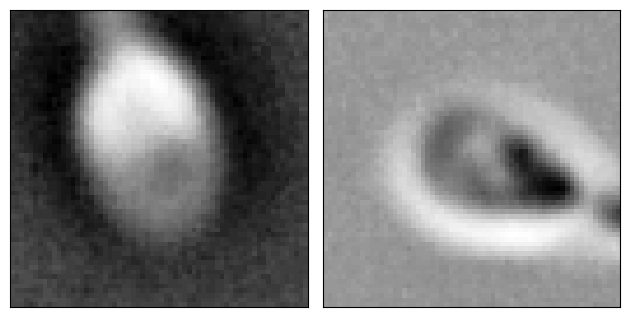

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(2):
    img = x_train_np[y_head_train_np == i][0]
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

plt.show()

Preparción de los datos en el formato adecuado

In [ ]:
x_train_np.dtype

dtype('uint8')

In [ ]:
#Normalizo la intensidad de los pixels para que queden entre 0,1
x_train_np_float = x_train_np / 255.0
x_valid_np_float = x_valid_np / 255.0
x_test_np_float = x_test_np / 255.0

In [ ]:
x_train_np_float[0:1]

array([[[0.50588235, 0.50980392, 0.51764706, ..., 0.51372549,
         0.51764706, 0.51764706],
        [0.49803922, 0.51372549, 0.52156863, ..., 0.51764706,
         0.51372549, 0.51372549],
        [0.50980392, 0.51764706, 0.51764706, ..., 0.51372549,
         0.50980392, 0.50980392],
        ...,
        [0.51764706, 0.52156863, 0.51372549, ..., 0.51372549,
         0.51372549, 0.51372549],
        [0.51764706, 0.52156863, 0.51764706, ..., 0.51372549,
         0.52156863, 0.50980392],
        [0.51372549, 0.51764706, 0.51764706, ..., 0.51764706,
         0.51764706, 0.51372549]]])

In [ ]:
batch=32

#Cambiar la forma de los datos
x_train_np = np.reshape(x_train_np_float,newshape=(1000,1,64,64))
x_valid_np = np.reshape(x_valid_np_float,newshape=(240,1,64,64))
x_test_np = np.reshape(x_test_np_float,newshape=(300,1,64,64))

# head, acrosome, vacuole
y_head_train_np = np.reshape(y_head_train_np,newshape=(1000))
y_head_valid_np = np.reshape(y_head_valid_np,newshape=(240))
y_head_test_np = np.reshape(y_head_test_np,newshape=(300))

y_acrosome_train_np = np.reshape(y_acrosome_train_np,newshape=(1000))
y_acrosome_valid_np = np.reshape(y_acrosome_valid_np,newshape=(240))
y_acrosome_test_np = np.reshape(y_acrosome_test_np,newshape=(300))

y_vacuole_train_np = np.reshape(y_vacuole_train_np,newshape=(1000))
y_vacuole_valid_np = np.reshape(y_vacuole_valid_np,newshape=(240))
y_vacuole_test_np = np.reshape(y_vacuole_test_np,newshape=(300))

#Convertir a tensores
tensor_x_train = torch.Tensor(x_train_np) # transform to torch tensor
tensor_x_valid = torch.Tensor(x_valid_np)
tensor_x_test = torch.Tensor(x_test_np)

tensor_y_head_train = torch.Tensor(y_head_train_np)
tensor_y_head_valid = torch.Tensor(y_head_valid_np)
tensor_y_head_test = torch.Tensor(y_head_test_np)

tensor_y_acrosome_train = torch.Tensor(y_acrosome_train_np)
tensor_y_acrosome_valid = torch.Tensor(y_acrosome_valid_np)
tensor_y_acrosome_test = torch.Tensor(y_acrosome_test_np)

tensor_y_vacuole_train = torch.Tensor(y_vacuole_train_np)
tensor_y_vacuole_valid = torch.Tensor(y_vacuole_valid_np)
tensor_y_vacuole_test = torch.Tensor(y_vacuole_test_np)


#Cargar los datos al DataLoader

#Head
dataset_train_head = TensorDataset(tensor_x_train,tensor_y_head_train)
dataset_valid_head = TensorDataset(tensor_x_valid,tensor_y_head_valid)
dataset_test_head = TensorDataset(tensor_x_test,tensor_y_head_test)

dataloader_train_head = DataLoader(dataset_train_head, batch_size=batch)
dataloader_valid_head = DataLoader(dataset_valid_head, batch_size=batch)
dataloader_test_head = DataLoader(dataset_test_head, batch_size=batch)

train_head = dataloader_train_head
valid_head = dataloader_valid_head
test_head = dataloader_test_head


#Acrosome
dataset_train_acrosome = TensorDataset(tensor_x_train,tensor_y_acrosome_train)
dataset_valid_acrosome = TensorDataset(tensor_x_valid,tensor_y_acrosome_valid)
dataset_test_acrosome = TensorDataset(tensor_x_test,tensor_y_acrosome_test)

dataloader_train_acrosome = DataLoader(dataset_train_acrosome, batch_size=batch)
dataloader_valid_acrosome = DataLoader(dataset_valid_acrosome, batch_size=batch)
dataloader_test_acrosome = DataLoader(dataset_test_acrosome, batch_size=batch)

train_acrosome = dataloader_train_acrosome
valid_acrosome = dataloader_valid_acrosome
test_acrosome = dataloader_test_acrosome

#Vacuole
dataset_train_vacuole = TensorDataset(tensor_x_train,tensor_y_vacuole_train)
dataset_valid_vacuole = TensorDataset(tensor_x_valid,tensor_y_vacuole_valid)
dataset_test_vacuole = TensorDataset(tensor_x_test,tensor_y_vacuole_test)

dataloader_train_vacuole = DataLoader(dataset_train_vacuole, batch_size=batch)
dataloader_valid_vacuole = DataLoader(dataset_valid_vacuole, batch_size=batch)
dataloader_test_vacuole = DataLoader(dataset_test_vacuole, batch_size=batch)

train_vacuole = dataloader_train_vacuole
valid_vacuole = dataloader_valid_vacuole
test_vacuole = dataloader_test_vacuole

In [ ]:
tensor_x_train.shape

torch.Size([1000, 1, 64, 64])

In [ ]:
tensor_y_head_train.shape

torch.Size([1000])

In [ ]:
for data, target in train_head:
    print(data.shape)
    print(target.shape)
    break

torch.Size([32, 1, 64, 64])
torch.Size([32])


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device




---



Definición de la función de entrenamiento

In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        if epoch % 10 == 0:
          print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid




---




## Modelo

La red neuronal propuesta por el paper tiene la siguiente forma:


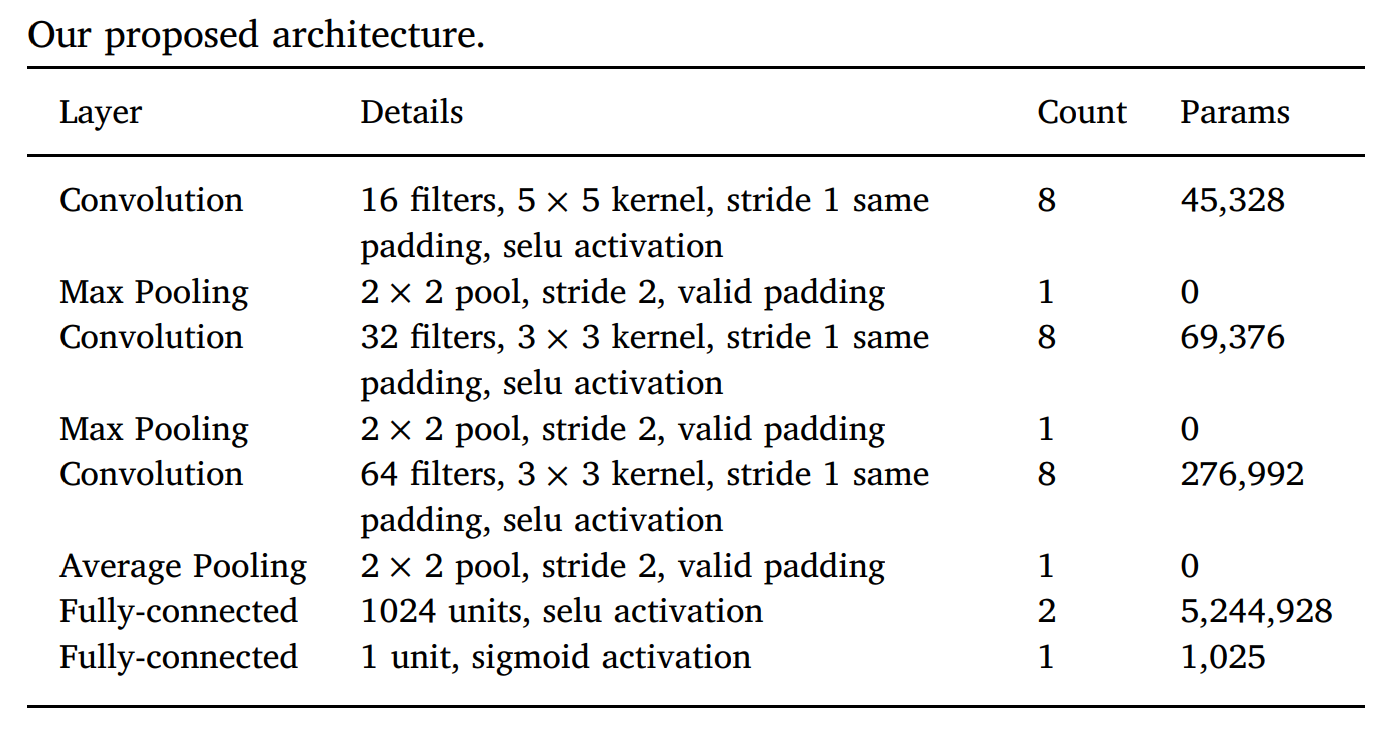

In [ ]:
modelo = nn.Sequential()

modelo.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=1))
modelo.add_module('selu1', nn.SELU())
modelo.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))

modelo.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1))
modelo.add_module('selu2', nn.SELU())
modelo.add_module('pool2', nn.MaxPool2d(kernel_size=2,stride=2))

modelo.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1))
modelo.add_module('selu3', nn.SELU())
modelo.add_module('pool3', nn.AvgPool2d(kernel_size=2, stride=2))

modelo.add_module('flatten2', nn.Flatten())
modelo.add_module('fully', nn.Linear(3136,1024))
modelo.add_module('selu4', nn.SELU())

modelo.add_module('fully2', nn.Linear(1024,1))
modelo.add_module('fully3', nn.Sigmoid())

In [ ]:
print(modelo)

Sequential(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (selu1): SELU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu2): SELU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu3): SELU()
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten2): Flatten(start_dim=1, end_dim=-1)
  (fully): Linear(in_features=3136, out_features=1024, bias=True)
  (selu4): SELU()
  (fully2): Linear(in_features=1024, out_features=1, bias=True)
  (fully3): Sigmoid()
)


Prueba del modelo

In [ ]:
prueba = torch.ones((1, 1, 64, 64))
modelo(prueba).shape

torch.Size([1, 1])

Defino 3 modelos distintos para entrenar por separado

In [ ]:
modelo_head=modelo
modelo_vacuole=modelo
modelo_acrosome=modelo

In [ ]:
accuracy_result={}
recall_result={}
precision_result={}
fb1_result={}
fb2_result={}

### Head

Tenia que entrenar usando menos epocas. Muestro 50 epocas


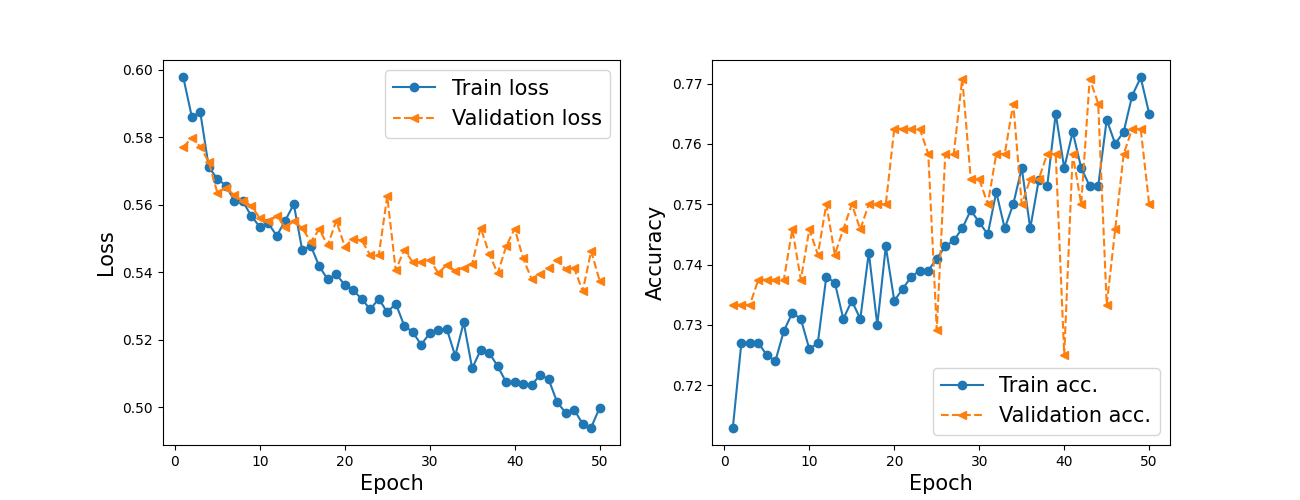

Entreno la cabeza usando mil épocas

In [ ]:
loss_fn= nn.BCELoss()

In [ ]:
num_epochs = 1000

torch.manual_seed(1)

optimizer=torch.optim.Adam(modelo_head.parameters(), lr=0.0001)

hist_head = train(modelo_head, num_epochs, train_head, valid_head)

x_arr = np.arange(len(hist_head[0])) + 1


Epoch 1 accuracy: 0.7190 val_accuracy: 0.7333
Epoch 2 accuracy: 0.7270 val_accuracy: 0.7333
Epoch 3 accuracy: 0.7270 val_accuracy: 0.7333
Epoch 4 accuracy: 0.7270 val_accuracy: 0.7333
Epoch 5 accuracy: 0.7250 val_accuracy: 0.7375
Epoch 6 accuracy: 0.7260 val_accuracy: 0.7375
Epoch 7 accuracy: 0.7330 val_accuracy: 0.7375
Epoch 8 accuracy: 0.7320 val_accuracy: 0.7375
Epoch 9 accuracy: 0.7320 val_accuracy: 0.7458
Epoch 10 accuracy: 0.7330 val_accuracy: 0.7458
Epoch 11 accuracy: 0.7330 val_accuracy: 0.7500
Epoch 12 accuracy: 0.7320 val_accuracy: 0.7417
Epoch 13 accuracy: 0.7340 val_accuracy: 0.7500
Epoch 14 accuracy: 0.7340 val_accuracy: 0.7500
Epoch 15 accuracy: 0.7350 val_accuracy: 0.7542
Epoch 16 accuracy: 0.7390 val_accuracy: 0.7500
Epoch 17 accuracy: 0.7380 val_accuracy: 0.7625
Epoch 18 accuracy: 0.7380 val_accuracy: 0.7583
Epoch 19 accuracy: 0.7360 val_accuracy: 0.7583
Epoch 20 accuracy: 0.7350 val_accuracy: 0.7625
Epoch 21 accuracy: 0.7390 val_accuracy: 0.7583
Epoch 22 accuracy: 0.7

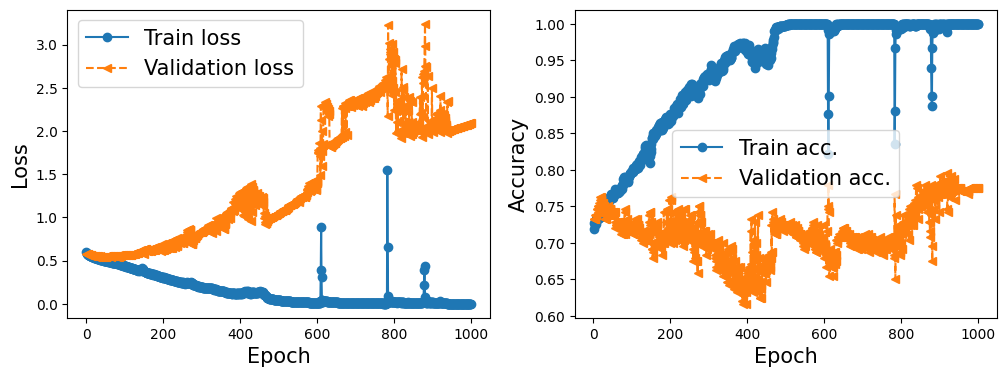

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_head[0], '-o', label='Train loss')
ax.plot(x_arr, hist_head[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_head[2], '-o', label='Train acc.')
ax.plot(x_arr, hist_head[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

A continuacion muestro curvas del paper, son mucho mas suaves que las que yo obengo. Trabaje en replicar estas imagenes sin exito, la red que entrene esta sobre entrenando.

Nota: Estoy mostrando epocas. La definición de iteración que utilizan en el paper es poca clara.  Uso "iteraciones" aca: [Link ](https://drive.google.com/drive/folders/1rDvjgyboou95jDfxRt3mcES9rA6lnc_h?usp=sharing)

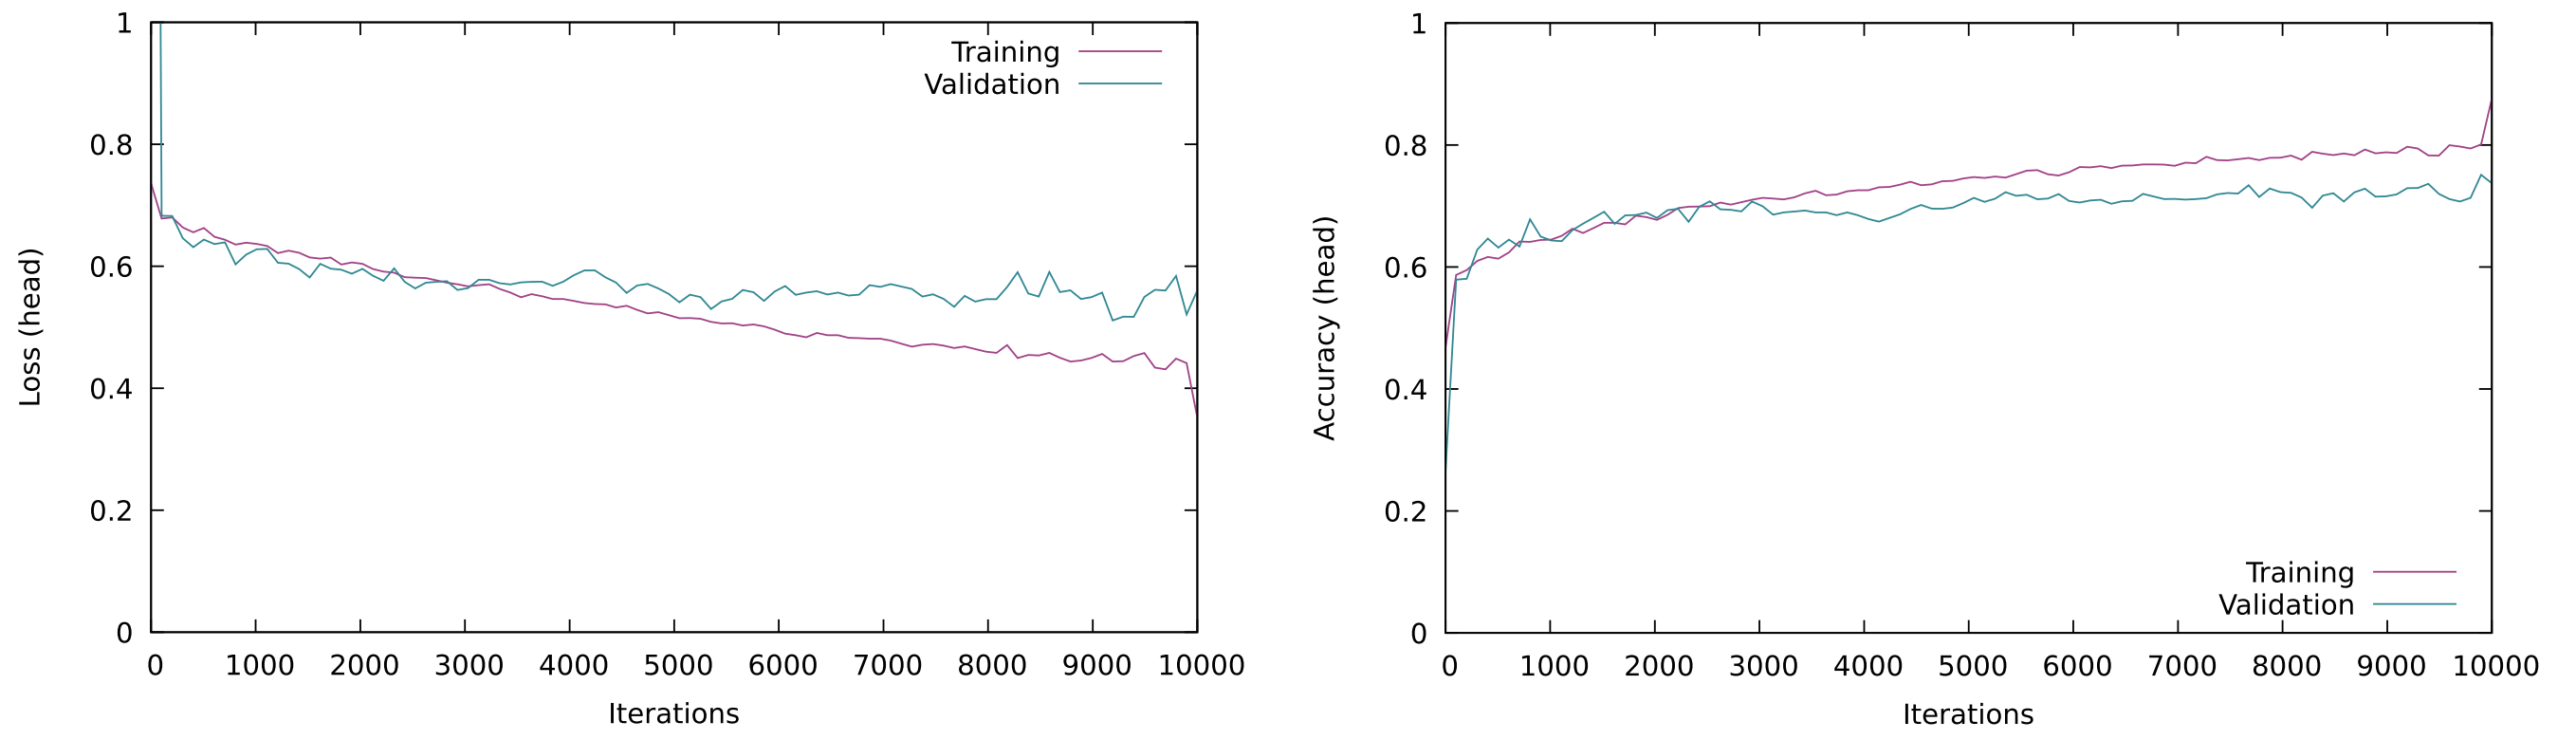

Muestro para la red las metricas y matriz de confusion

Test accuracy: 0.7300
0.7233333333333334 0.4074074074074074 0.4852941176470588 0.44704737669336125 0.4429916897410146


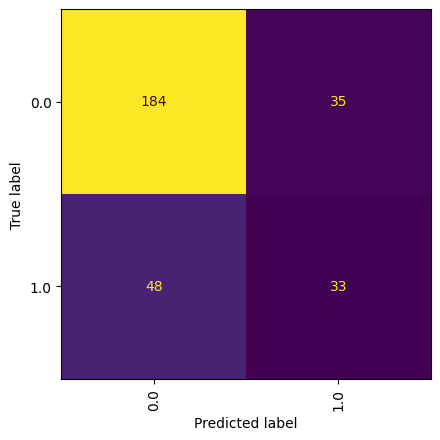

In [ ]:

pred = modelo_head(tensor_x_test)
is_correct = (torch.argmax(pred, dim=1) == tensor_y_head_test).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

#pred = model(tensor_x_test)
pred_np = pred.detach().numpy()
pred_npy = (pred_np > 0.5).astype(int)
y_head_test_npy = y_head_test_np.astype(np.float32)

accuracy_result[3]= accuracy_score(y_head_test_npy,pred_npy)
recall_result[3]=recall_score(y_head_test_npy,pred_npy,pos_label=1)
precision_result[3]=precision_score(y_head_test_npy,pred_npy,pos_label=1)
fb1_result[3]=fbeta_score(y_head_test_npy,pred_npy,beta=0.9)
fb2_result[3]=fbeta_score(y_head_test_npy,pred_npy,beta=0.999)

print(accuracy_result[3],recall_result[3],precision_result[3],fb1_result[3],fb2_result[3])

ConfusionMatrixDisplay.from_predictions(y_head_test_npy,pred_npy,
                                        colorbar=False,
                                        xticks_rotation='vertical')
plt.show()

Agrego una imagen del entrenamiento con 10mil epocas que hize en mi computadora. Colab es muy lento para esto.

Tiempo de corrida: 3:12:45.218648 , (3 horas, 12 minutos)

Procesador: AMD Ryzen 7 5700G with Radeon Graphics. 3.80 GHz

RAM=32 GB

Test accuracy: 0.7300

Metricas:

accuracy=0.73   

recall=0.4074074074074074   

precision=0.5    

fb (beta=0.9) = 0.4538408935491224

fb (beta=0.999) = 0.44902543366798703  

roc_auc =  0.6283612379502791  

mcc= 0.2751367246529054

Matriz de confusion:

[186  33]

 [ 48  33]

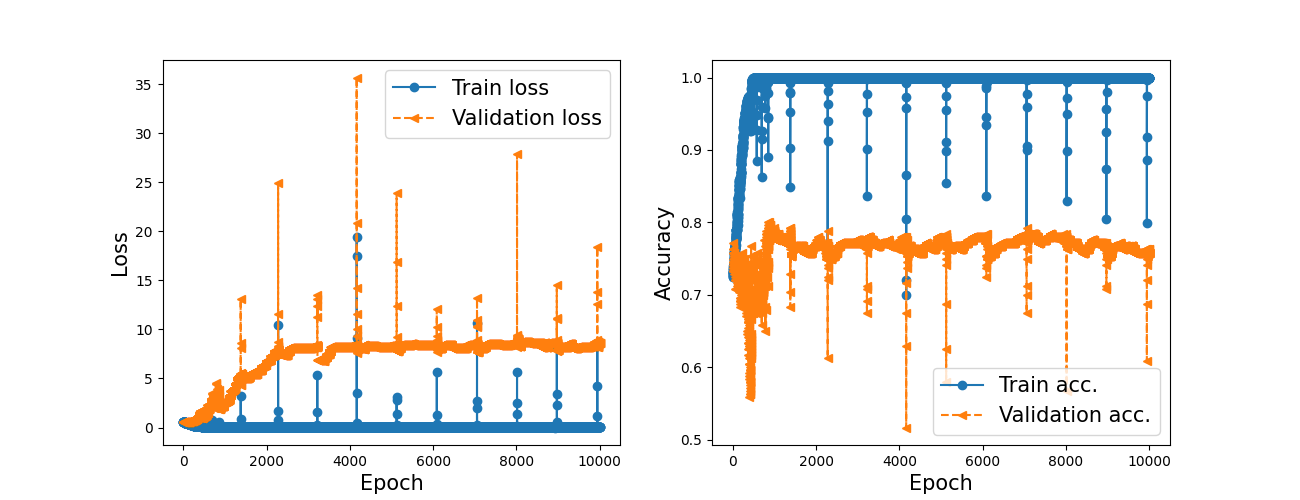

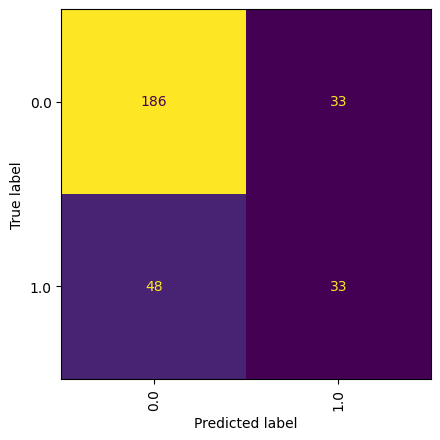

Siguen el entrenaminto para clasificar la forma del acrosoma y la vacuola, me dan graficos parecidos. Para saltar esta parte ir a "Cambio en el modelado"

### Acrosoma

Epoch 1 accuracy: 0.6910 val_accuracy: 0.7042
Epoch 2 accuracy: 0.7180 val_accuracy: 0.6583
Epoch 3 accuracy: 0.7190 val_accuracy: 0.6500
Epoch 4 accuracy: 0.7250 val_accuracy: 0.6042
Epoch 5 accuracy: 0.7360 val_accuracy: 0.6292
Epoch 6 accuracy: 0.7460 val_accuracy: 0.5667
Epoch 7 accuracy: 0.7490 val_accuracy: 0.5708
Epoch 8 accuracy: 0.7580 val_accuracy: 0.5833
Epoch 9 accuracy: 0.7560 val_accuracy: 0.5833
Epoch 10 accuracy: 0.7570 val_accuracy: 0.5833
Epoch 11 accuracy: 0.7670 val_accuracy: 0.5833
Epoch 12 accuracy: 0.7660 val_accuracy: 0.5792
Epoch 13 accuracy: 0.7680 val_accuracy: 0.5875
Epoch 14 accuracy: 0.7760 val_accuracy: 0.5917
Epoch 15 accuracy: 0.7760 val_accuracy: 0.5917
Epoch 16 accuracy: 0.7840 val_accuracy: 0.5875
Epoch 17 accuracy: 0.7890 val_accuracy: 0.5958
Epoch 18 accuracy: 0.7940 val_accuracy: 0.6083
Epoch 19 accuracy: 0.7990 val_accuracy: 0.6167
Epoch 20 accuracy: 0.7990 val_accuracy: 0.6208
Epoch 21 accuracy: 0.7990 val_accuracy: 0.6167
Epoch 22 accuracy: 0.8

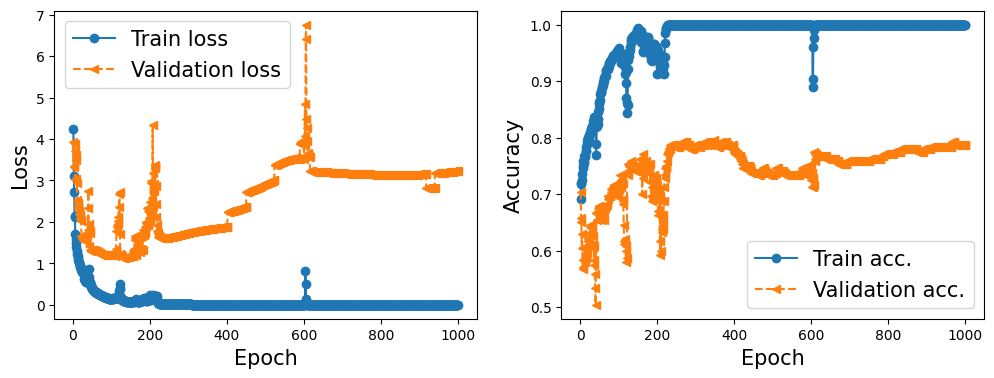

Test accuracy: 0.7100
0.71 0.47126436781609193 0.5 0.48671869876041196 0.48522146343414335


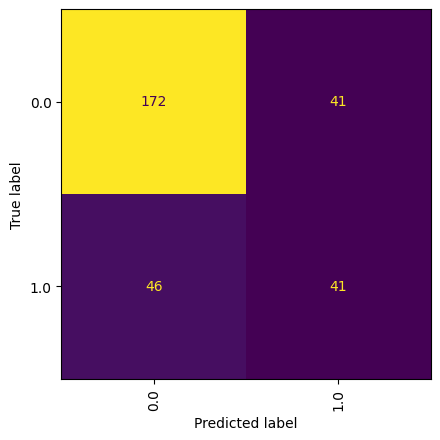

In [ ]:
num_epochs = 1000
torch.manual_seed(1)

optimizer=torch.optim.Adam(modelo_acrosome.parameters(), lr=0.0001)

hist_acrosome = train(modelo_acrosome, num_epochs, train_acrosome, valid_acrosome)

x_arr = np.arange(len(hist_acrosome[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_acrosome[0], '-o', label='Train loss')
ax.plot(x_arr, hist_acrosome[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_acrosome[2], '-o', label='Train acc.')
ax.plot(x_arr, hist_acrosome[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()


pred = modelo_acrosome(tensor_x_test)
is_correct = (torch.argmax(pred, dim=1) == tensor_y_acrosome_test).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

#pred = modelo_acrosome(tensor_x_test)
pred_np = pred.detach().numpy()
pred_npy = (pred_np > 0.5).astype(int)
y_acrosome_test_npy = y_acrosome_test_np.astype(np.float32)

accuracy_result[4]= accuracy_score(y_acrosome_test_npy,pred_npy)
recall_result[4]=recall_score(y_acrosome_test_npy,pred_npy,pos_label=1)
precision_result[4]=precision_score(y_acrosome_test_npy,pred_npy,pos_label=1)
fb1_result[4]=fbeta_score(y_acrosome_test_npy,pred_npy,beta=0.9)
fb2_result[4]=fbeta_score(y_acrosome_test_npy,pred_npy,beta=0.999)

print(accuracy_result[4],recall_result[4],precision_result[4],fb1_result[4],fb2_result[4])

ConfusionMatrixDisplay.from_predictions(y_acrosome_test_npy,pred_npy,
                                        colorbar=False,
                                        xticks_rotation='vertical')
plt.show()

Imagenes reportadas en el paper:
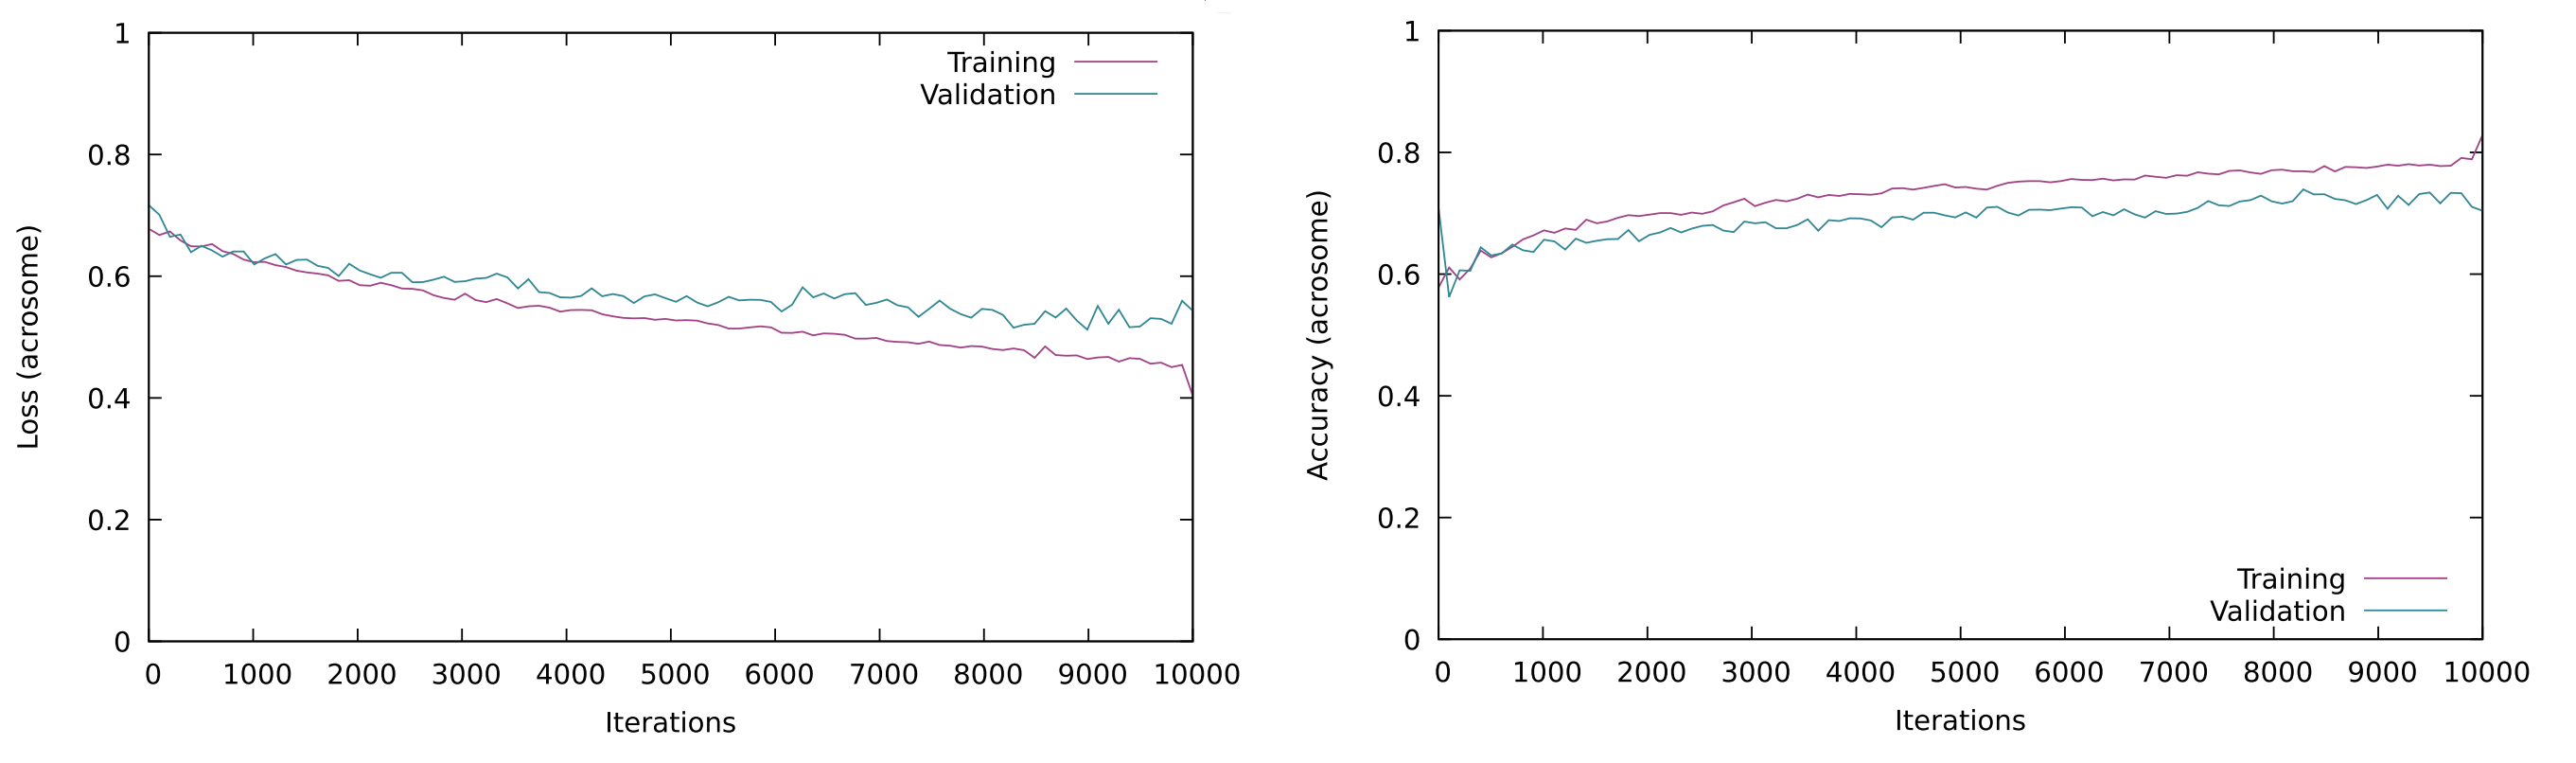

Entrenamiento con 10000 epocas
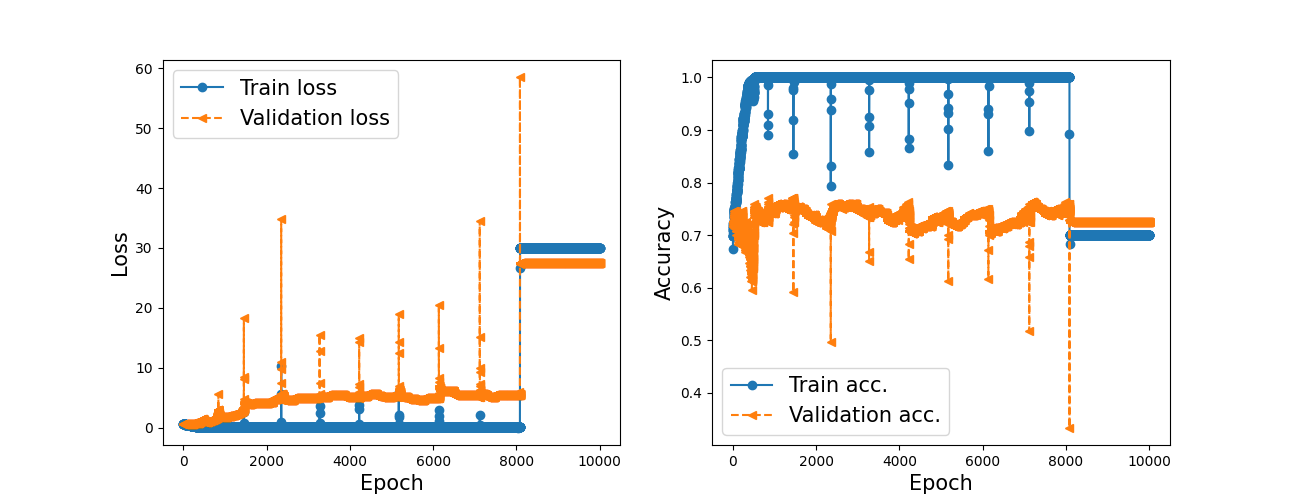

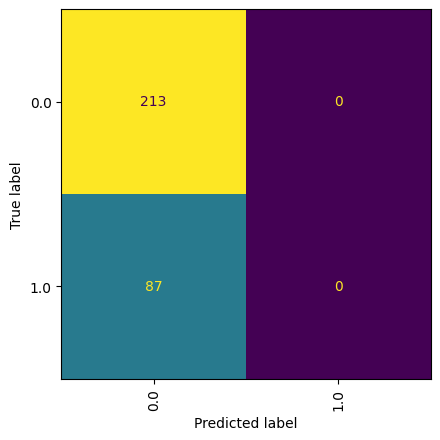

Esta red esta sobre entrenando demasiado y aprende mal. Tengo tambien la misma red para vacuola ver: [Link](https://drive.google.com/drive/folders/1rDvjgyboou95jDfxRt3mcES9rA6lnc_h?usp=sharing) Pasa lo mismo.

### Vacuole

Epoch 1 accuracy: 0.7920 val_accuracy: 0.8000
Epoch 2 accuracy: 0.8330 val_accuracy: 0.7833
Epoch 3 accuracy: 0.8380 val_accuracy: 0.8292
Epoch 4 accuracy: 0.8560 val_accuracy: 0.8375
Epoch 5 accuracy: 0.8570 val_accuracy: 0.8792
Epoch 6 accuracy: 0.8760 val_accuracy: 0.8500
Epoch 7 accuracy: 0.8840 val_accuracy: 0.8500
Epoch 8 accuracy: 0.8780 val_accuracy: 0.8542
Epoch 9 accuracy: 0.8900 val_accuracy: 0.8542
Epoch 10 accuracy: 0.8920 val_accuracy: 0.8208
Epoch 11 accuracy: 0.8870 val_accuracy: 0.7875
Epoch 12 accuracy: 0.8880 val_accuracy: 0.8667
Epoch 13 accuracy: 0.8960 val_accuracy: 0.8792
Epoch 14 accuracy: 0.9080 val_accuracy: 0.8417
Epoch 15 accuracy: 0.9110 val_accuracy: 0.7958
Epoch 16 accuracy: 0.8920 val_accuracy: 0.8125
Epoch 17 accuracy: 0.9140 val_accuracy: 0.8583
Epoch 18 accuracy: 0.9210 val_accuracy: 0.8667
Epoch 19 accuracy: 0.9210 val_accuracy: 0.8667
Epoch 20 accuracy: 0.9230 val_accuracy: 0.8500
Epoch 21 accuracy: 0.9240 val_accuracy: 0.7625
Epoch 22 accuracy: 0.9

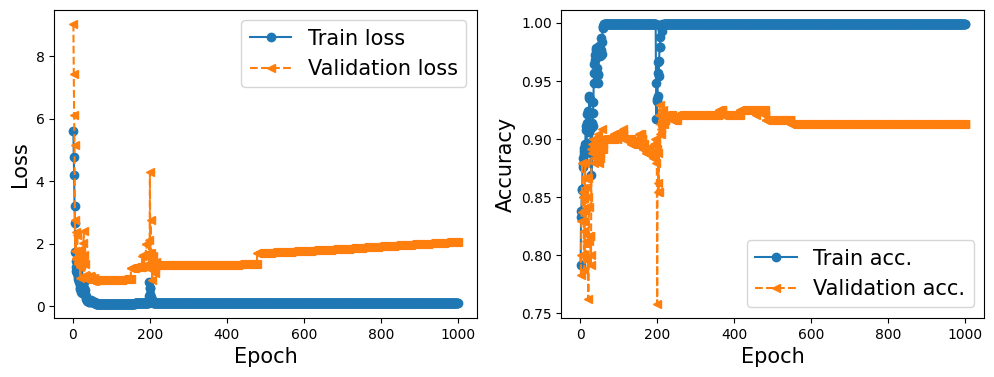

In [ ]:
num_epochs = 1000
torch.manual_seed(1)

optimizer=torch.optim.Adam(modelo_vacuole.parameters(), lr=0.0001)

hist_vacuole = train(modelo_vacuole, num_epochs, train_vacuole, valid_vacuole)

x_arr = np.arange(len(hist_vacuole[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_vacuole[0], '-o', label='Train loss')
ax.plot(x_arr, hist_vacuole[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_vacuole[2], '-o', label='Train acc.')
ax.plot(x_arr, hist_vacuole[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

Imagenes reportadas en el paper:

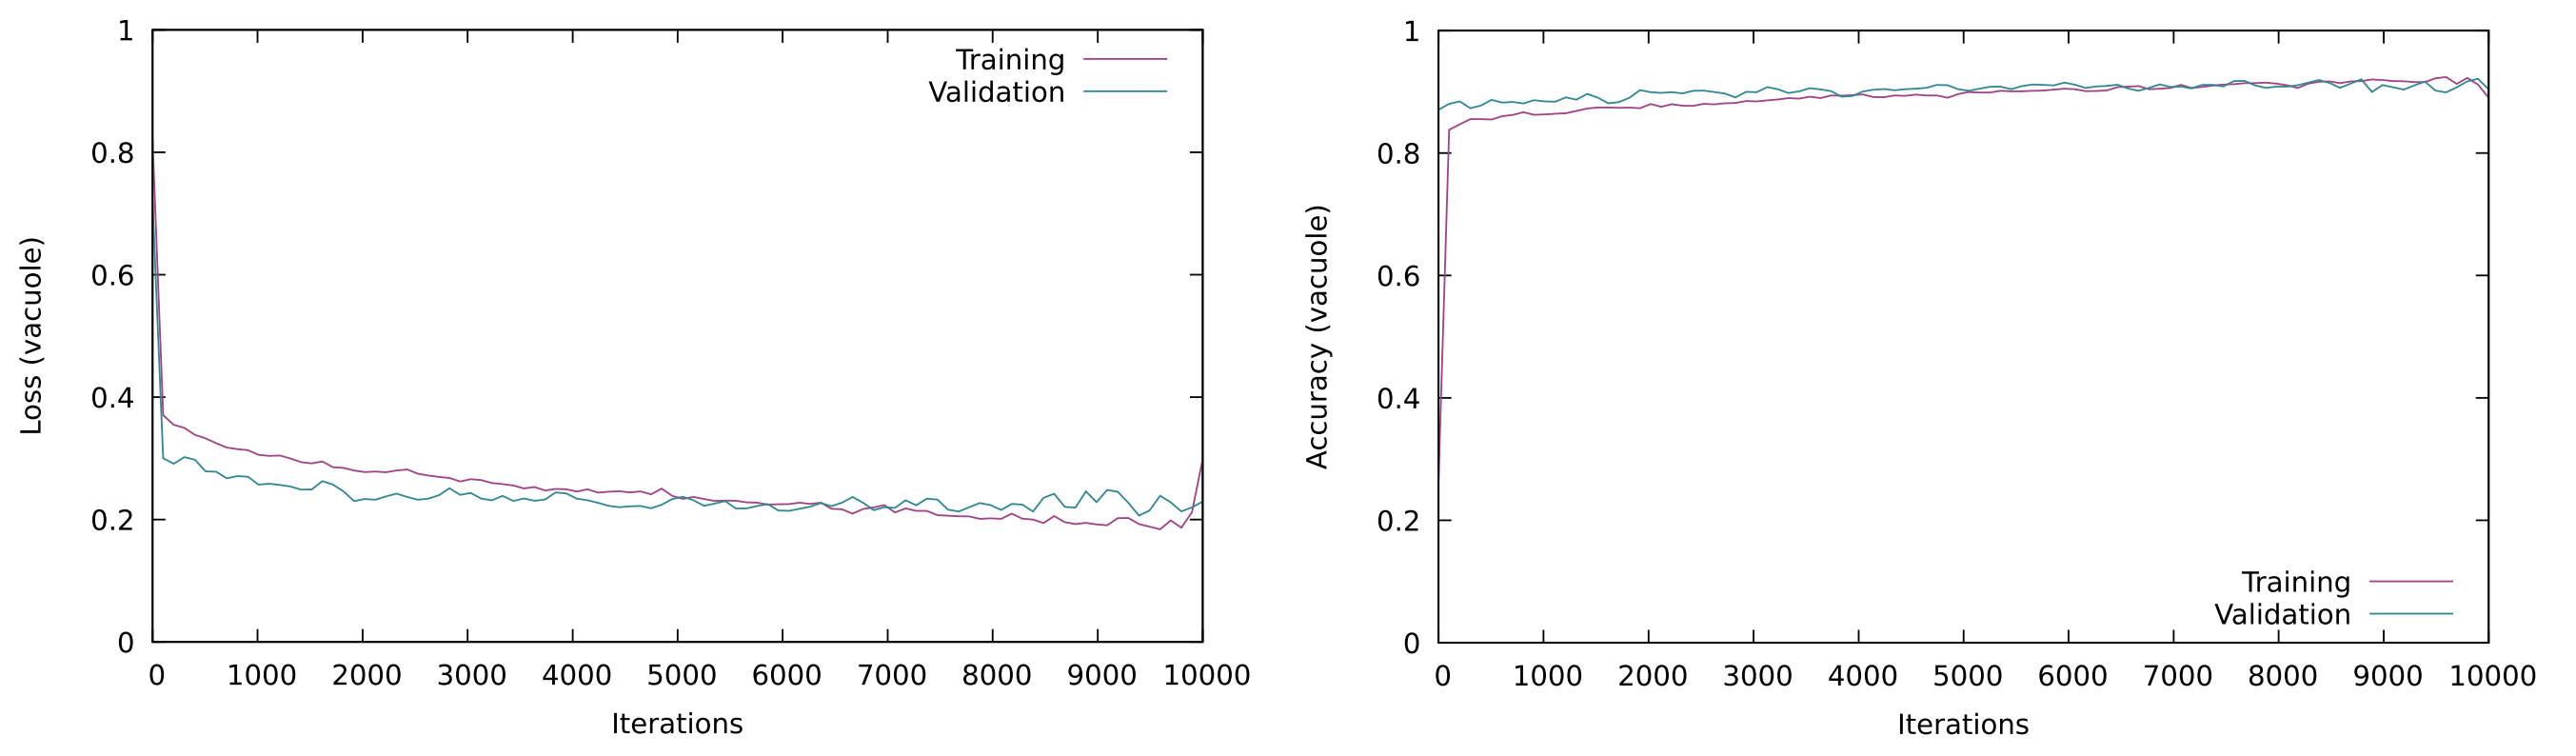

Test accuracy: 0.8733
0.8833333333333333 0.5263157894736842 0.5405405405405406 0.534080849808203 0.5333404480949092


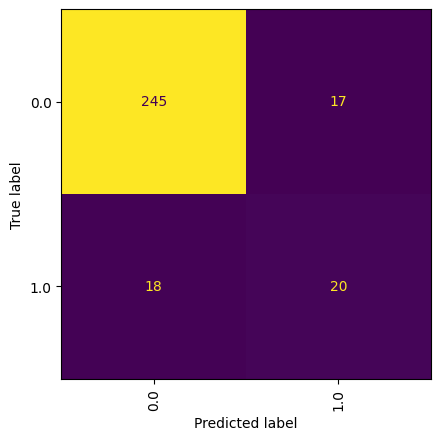

In [ ]:

pred = modelo_vacuole(tensor_x_test)
is_correct = (torch.argmax(pred, dim=1) == tensor_y_vacuole_test).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

#pred = model(tensor_x_test)
pred_np = pred.detach().numpy()
pred_npy = (pred_np > 0.5).astype(int)
y_vacuole_test_npy = y_vacuole_test_np.astype(np.float32)

accuracy_result[5]= accuracy_score(y_vacuole_test_npy,pred_npy)
recall_result[5]=recall_score(y_vacuole_test_npy,pred_npy,pos_label=1)
precision_result[5]=precision_score(y_vacuole_test_npy,pred_npy,pos_label=1)
fb1_result[5]=fbeta_score(y_vacuole_test_npy,pred_npy,beta=0.9)
fb2_result[5]=fbeta_score(y_vacuole_test_npy,pred_npy,beta=0.999)

print(accuracy_result[5],recall_result[5],precision_result[5],fb1_result[5],fb2_result[5])

ConfusionMatrixDisplay.from_predictions(y_vacuole_test_npy,pred_npy,
                                        colorbar=False,
                                        xticks_rotation='vertical')
plt.show()

Hago una tabla con los valores obtenidos

In [ ]:
accuracy_list = [accuracy_result[n] for n in range(3,6)]
recall_list = [recall_result[n] for n in range(3,6)]
precision_list = [precision_result[n] for n in range(3,6)]
fb1_score_list = [fb1_result[n] for n in range(3,6)]
fb2_score_list = [fb2_result[n] for n in range(3,6)]



tabla2=pd.DataFrame({
    "Clase":['head','acrosome','vacuole'],
    "accuracy": accuracy_list,
    "recall":recall_list,
    "precision": precision_list,
    "fb1_score": fb1_score_list,
    "fb2_score": fb2_score_list
})

tabla2

,Clase,accuracy,recall,precision,fb1_score,fb2_score
0,head,0.740000,0.432099,0.522388,0.477717,0.473018
1,acrosome,0.710000,0.471264,0.500000,0.486719,0.485221
2,vacuole,0.883333,0.526316,0.540541,0.534081,0.533340



Comparo los datos obtenidos con los reportados en el paper:

In [ ]:
accuracy_list = [76.67, 77.0, 91.33]
recall_list = [80.28,85.39,95.80]
precision_list = [85.93,83.48,94.36]
fb1_score_list = [84.74,83.86,94.65]
#fb2_score_list = []
roc_auc_list = [83.89,77.80,88.08]
mcc_list = [0.4618,0.4053,0.5910]

tabla4=pd.DataFrame({
    "Clase":['head','acrosome','vacuole'],
    "accuracy": accuracy_list,
    "recall":recall_list,
    "precision": precision_list,
    "f0_score": fb1_score_list,
#    "fb2_score": fb2_score_list,
    "roc_auc" : roc_auc_list,
    "mcc" : mcc_list
})

print(tabla4)

      Clase  accuracy  recall  precision  f0_score  roc_auc     mcc
0      head     76.67   80.28      85.93     84.74    83.89  0.4618
1  acrosome     77.00   85.39      83.48     83.86    77.80  0.4053
2   vacuole     91.33   95.80      94.36     94.65    88.08  0.5910




---



 ## Cambio en el modelado

 Con la idea de que son demasiadas conexiones para el problema, pruebo reduciendo el numero de conexiones a la ultima capa. Empiezo entrenando la deteccion de la cabeza




### Head

N=128

In [ ]:
modelo_capas3 = nn.Sequential()
modelo_capas3.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=1))
modelo_capas3.add_module('selu1', nn.SELU())
modelo_capas3.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))
modelo_capas3.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1))
modelo_capas3.add_module('selu2', nn.SELU())
modelo_capas3.add_module('pool2', nn.MaxPool2d(kernel_size=2,stride=2))
modelo_capas3.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1))
modelo_capas3.add_module('selu3', nn.SELU())
modelo_capas3.add_module('pool3', nn.AvgPool2d(kernel_size=2, stride=2))
modelo_capas3.add_module('flatten2', nn.Flatten())
modelo_capas3.add_module('fully', nn.Linear(3136,128))
modelo_capas3.add_module('selu4', nn.SELU())
modelo_capas3.add_module('fully2', nn.Linear(128,1))
modelo_capas3.add_module('fully3', nn.Sigmoid())

In [ ]:
modelo_capas3_head= modelo_capas3
modelo_capas3_acrosome = modelo_capas3
modelo_capas3_vacuole = modelo_capas3

In [ ]:
num_epochs = 60
torch.manual_seed(1)

optimizer=torch.optim.Adam(modelo_capas3_head.parameters(), lr=0.0001)

hist_head_capas3 = train(modelo_capas3_head, num_epochs, train_head, valid_head)

Epoch 1 accuracy: 0.7270 val_accuracy: 0.7333
Epoch 11 accuracy: 0.7310 val_accuracy: 0.7375
Epoch 21 accuracy: 0.7310 val_accuracy: 0.7458
Epoch 31 accuracy: 0.7420 val_accuracy: 0.7583
Epoch 41 accuracy: 0.7420 val_accuracy: 0.7542
Epoch 51 accuracy: 0.7570 val_accuracy: 0.7583


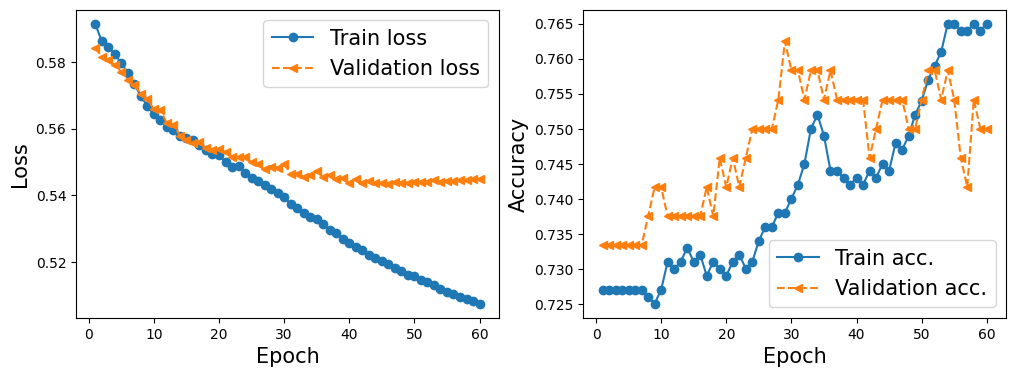

In [ ]:
hist=hist_head_capas3

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

Me quedo con este modelo

Test accuracy: 0.7300
0.71 0.2222222222222222 0.42857142857142855 0.30275996654586 0.29277580459759867 0.556316590563166 0.14411076342379642


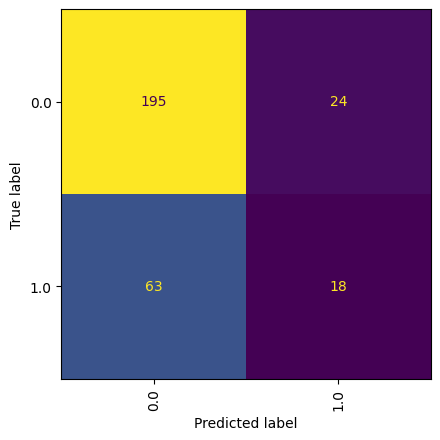

In [ ]:
pred = modelo_capas3_head(tensor_x_test)
is_correct = (torch.argmax(pred, dim=1) == tensor_y_head_test).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

#pred = model(tensor_x_test)
pred_np = pred.detach().numpy()
pred_npy = (pred_np > 0.5).astype(int)
y_head_test_npy = y_head_test_np.astype(np.float32)

accuracy_result= accuracy_score(y_head_test_npy,pred_npy)
recall_result=recall_score(y_head_test_npy,pred_npy,pos_label=1)
precision_result=precision_score(y_head_test_npy,pred_npy,pos_label=1)
fb1_result=fbeta_score(y_head_test_npy,pred_npy,beta=0.9)
fb2_result=fbeta_score(y_head_test_npy,pred_npy,beta=0.999)
roc_auc_result=roc_auc_score(y_head_test_npy,pred_npy)
mcc_result=matthews_corrcoef(y_head_test_npy,pred_npy)

print(accuracy_result,recall_result,precision_result,fb1_result,fb2_result,roc_auc_result,mcc_result)

ConfusionMatrixDisplay.from_predictions(y_head_test_npy,pred_npy,
                                        colorbar=False,
                                        xticks_rotation='vertical')
plt.show()

Tabla con las metricas cambiando el número de neuronas, codigo corrido en mi compu


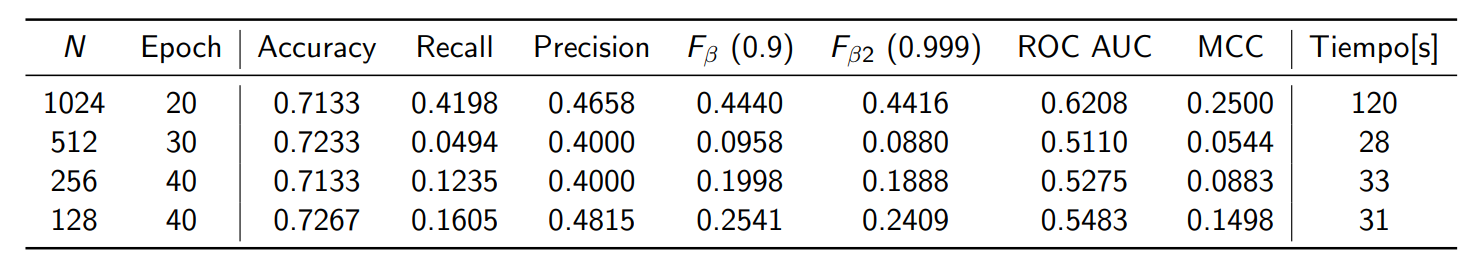

### Acrosoma

Usando este ultimo modelo entreno clasificacíón para acrosoma

In [ ]:
num_epochs = 70
torch.manual_seed(1)

optimizer=torch.optim.Adam(modelo_capas3_acrosome.parameters(), lr=0.0001)

hist_acrosome_capas3 = train(modelo_capas3_acrosome, num_epochs, train_acrosome, valid_acrosome)

Epoch 1 accuracy: 0.7100 val_accuracy: 0.7375
Epoch 11 accuracy: 0.7340 val_accuracy: 0.7458
Epoch 21 accuracy: 0.7350 val_accuracy: 0.7458
Epoch 31 accuracy: 0.7350 val_accuracy: 0.7458
Epoch 41 accuracy: 0.7410 val_accuracy: 0.7583
Epoch 51 accuracy: 0.7510 val_accuracy: 0.7583
Epoch 61 accuracy: 0.7430 val_accuracy: 0.7542


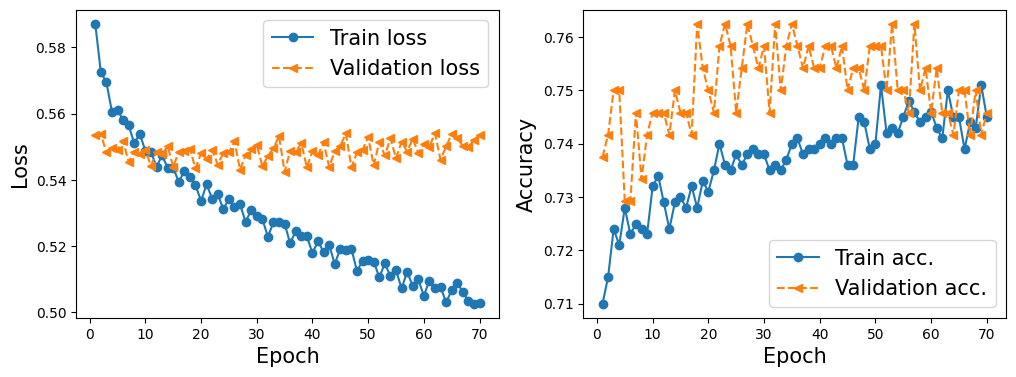

In [ ]:
hist=hist_acrosome_capas3

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

Test accuracy: 0.7100
0.71 0.28735632183908044 0.5102040816326531 0.3787561730978488 0.3677498638387484 0.5873401327505261 0.21441658296086666


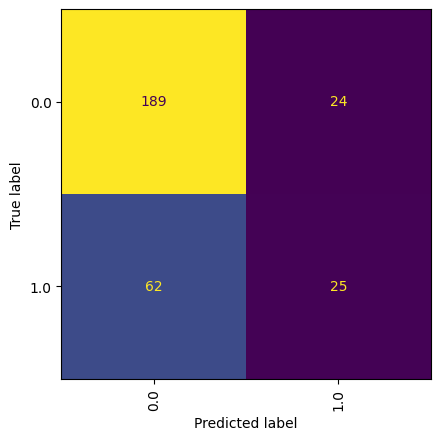

In [ ]:
pred = modelo_capas3_acrosome(tensor_x_test)
is_correct = (torch.argmax(pred, dim=1) == tensor_y_acrosome_test).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

pred_np = pred.detach().numpy()
pred_npy = (pred_np > 0.5).astype(int)
y_acrosome_test_npy = y_acrosome_test_np.astype(np.float32)

accuracy_result_= accuracy_score(y_acrosome_test_npy,pred_npy)
recall_result=recall_score(y_acrosome_test_npy,pred_npy,pos_label=1)
precision_result=precision_score(y_acrosome_test_npy,pred_npy,pos_label=1)
fb1_result=fbeta_score(y_acrosome_test_npy,pred_npy,beta=0.9)
fb2_result=fbeta_score(y_acrosome_test_npy,pred_npy,beta=0.999)
roc_auc_result=roc_auc_score(y_acrosome_test_npy,pred_npy)
mcc_result=matthews_corrcoef(y_acrosome_test_npy,pred_npy)

print(accuracy_result,recall_result,precision_result,fb1_result,fb2_result,roc_auc_result,mcc_result)

ConfusionMatrixDisplay.from_predictions(y_acrosome_test_npy,pred_npy,
                                        colorbar=False,
                                        xticks_rotation='vertical')
plt.show()

### Vacuola

Lo mismo para Vacuola

In [ ]:
num_epochs = 40
torch.manual_seed(1)

optimizer=torch.optim.Adam(modelo_capas3_vacuole.parameters(), lr=0.0001)

hist_vacuole_capas3 = train(modelo_capas3_vacuole, num_epochs, train_vacuole, valid_vacuole)

Epoch 1 accuracy: 0.8120 val_accuracy: 0.8708
Epoch 11 accuracy: 0.8530 val_accuracy: 0.8667
Epoch 21 accuracy: 0.8570 val_accuracy: 0.8958
Epoch 31 accuracy: 0.8660 val_accuracy: 0.8667


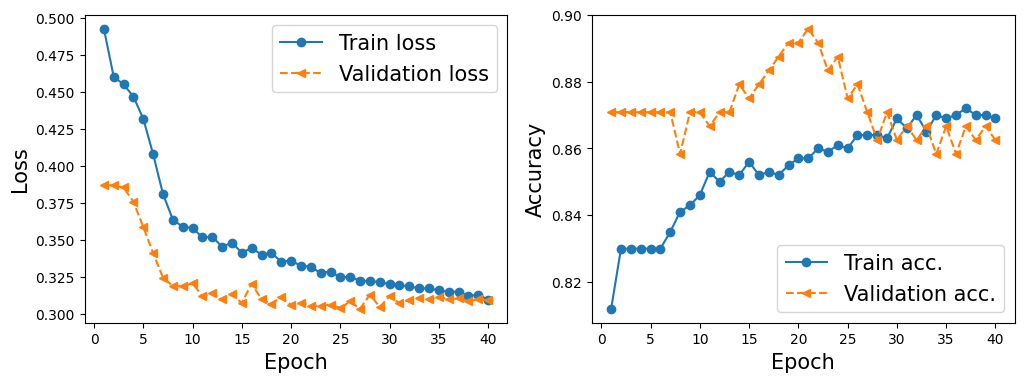

In [ ]:
hist=hist_vacuole_capas3

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

Test accuracy: 0.8733
0.87 0.42105263157894735 0.48484848484848486 0.45406083411727816 0.45073598319373753 0.6780835676978705 0.37860268245257866


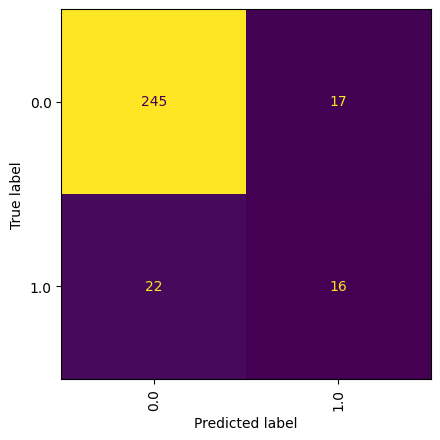

In [ ]:
pred = modelo_capas3_vacuole(tensor_x_test)
is_correct = (torch.argmax(pred, dim=1) == tensor_y_vacuole_test).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

pred_np = pred.detach().numpy()
pred_npy = (pred_np > 0.5).astype(int)
y_vacuole_test_npy = y_vacuole_test_np.astype(np.float32)

accuracy_result= accuracy_score(y_vacuole_test_npy,pred_npy)
recall_result=recall_score(y_vacuole_test_npy,pred_npy,pos_label=1)
precision_result=precision_score(y_vacuole_test_npy,pred_npy,pos_label=1)
fb1_result=fbeta_score(y_vacuole_test_npy,pred_npy,beta=0.9)
fb2_result=fbeta_score(y_vacuole_test_npy,pred_npy,beta=0.999)
roc_auc_result=roc_auc_score(y_vacuole_test_npy,pred_npy)
mcc_result=matthews_corrcoef(y_vacuole_test_npy,pred_npy)

print(accuracy_result,recall_result,precision_result,fb1_result,fb2_result,roc_auc_result,mcc_result)

ConfusionMatrixDisplay.from_predictions(y_vacuole_test_npy,pred_npy,
                                        colorbar=False,
                                        xticks_rotation='vertical')
plt.show()


---

 ## Data augmentation

 El conjunto de entrenamiento posee más casos de celulas normales que anormales. Para mejorar el entrenamiento aumento el conjunto de imagenes de células anormales realizandole transformadas a las imagenes originales.

Las 4 transformaciónes realizadas al conjunto de imagenes son:


*   Rotar un ángulo theta que es elegido de forma random de una distribucion uniforme de [0,360)
*   Shifting: Mover en x e y tx y ty pixeles, donde estos son elegidos de forma random entre -5 a 5
*   Flipping: flip la imagen horizontalmente (mirror) y verticalmente (reflect) cada un con una chance de 0.5


Muestro ahora una ejemplo de aplicar cada una de las transformaciones

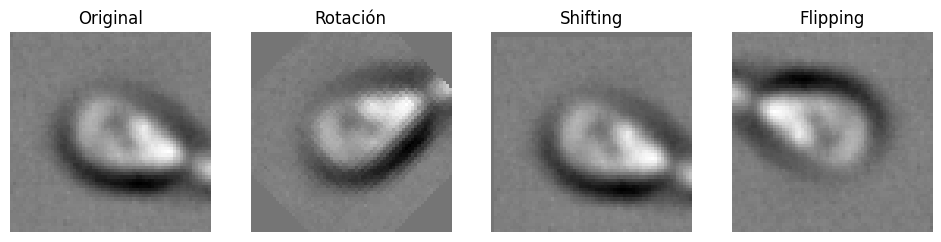

In [ ]:
# Cargar los datos
x_train_np = np.load('mhsma-dataset/mhsma/x_64_train.npy')


# Convertir x_train_true a un tensor de PyTorch
x_train_tensor = torch.tensor(x_train_np, dtype=torch.float32)

# Definir las transformaciones individuales
beta = math.log(1.25)  # Valor de beta para el cambio de brillo

# 1. Rotación
transform_rotation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=(0, 360),fill=128),  # Rotación aleatoria entre 0 y 360 grados
    transforms.ToTensor(),
])

# 2. Shifting
transform_shifting = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05),fill=128),  # Shifting aleatorio entre -5 y 5 píxeles
    transforms.ToTensor(),
])

# 3. Flipping
transform_flipping = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=1.0),  # Flip horizontal con probabilidad 1.0
    transforms.RandomVerticalFlip(p=1.0),  # Flip vertical con probabilidad 1.0
    transforms.ToTensor(),
])

# 4. Cambio de brillo
transform_brightness = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=(1 / math.exp(beta), math.exp(beta))),  # Cambio de brillo
    transforms.ToTensor(),
])

# Seleccionar una imagen para mostrar
image_to_transform = x_train_tensor[0]  # Selecciona la primera imagen


# Asegurar que la imagen tenga 3 dimensiones (C, H, W)
if image_to_transform.dim() == 2:  # Si es 2D (H, W)
    image_to_transform = image_to_transform.unsqueeze(0)  # Convertir a (1, H, W)


# Normalizar la imagen original
image_to_transform = image_to_transform / 255.0

# Convertir a numpy para visualizar con imshow()
image_np = image_to_transform.numpy()

# Si es en escala de grises (1, H, W), convertir a (H, W)
if image_np.shape[0] == 1:
    image_np = image_np.squeeze(0)

# Crear una figura para mostrar las imágenes
plt.figure(figsize=(15, 5))

# Mostrar la imagen original
image_np=image_np-1
plt.subplot(1, 5, 1)
plt.imshow(image_np, cmap='gray')
plt.title("Original")
plt.axis('off')

# Aplicar y mostrar la transformación de rotación
transformed_image_rotation = transform_rotation(image_to_transform)
plt.subplot(1, 5, 2)
plt.imshow(transformed_image_rotation.squeeze(0), cmap='gray')
plt.title("Rotación")
plt.axis('off')

# Aplicar y mostrar la transformación de shifting
transformed_image_shifting = transform_shifting(image_to_transform)
plt.subplot(1, 5, 3)
plt.imshow(transformed_image_shifting.squeeze(0), cmap='gray')
plt.title("Shifting")
plt.axis('off')

# Aplicar y mostrar la transformación de flipping
transformed_image_flipping = transform_flipping(image_to_transform)
plt.subplot(1, 5, 4)
plt.imshow(transformed_image_flipping.squeeze(0), cmap='gray')
plt.title("Flipping")
plt.axis('off')


plt.show()

### Head

Aca me hice problemas con las versiones de python, en mi compu corre bien. Agrego los resultados aca, no llegue a arreglar esto en el colab. Link al drive donde puse el codigo del programa que corro con los detalles: Link

In [ ]:
x_train_np = np.load('mhsma-dataset/mhsma/x_64_train.npy')
x_test_np = np.load('mhsma-dataset/mhsma/x_64_test.npy')
x_valid_np= np.load('mhsma-dataset/mhsma/x_64_valid.npy')

y_acrosome_train_np = np.load('mhsma-dataset/mhsma/y_acrosome_train.npy')
y_acrosome_test_np = np.load('mhsma-dataset/mhsma/y_acrosome_test.npy')
y_acrosome_valid_np = np.load('mhsma-dataset/mhsma/y_acrosome_valid.npy')

y_head_train_np = np.load('mhsma-dataset/mhsma/y_head_train.npy')
y_head_test_np = np.load('mhsma-dataset/mhsma/y_head_test.npy')
y_head_valid_np = np.load('mhsma-dataset/mhsma/y_head_valid.npy')

y_vacuole_train_np = np.load('mhsma-dataset/mhsma/y_vacuole_train.npy')
y_vacuole_test_np = np.load('mhsma-dataset/mhsma/y_vacuole_test.npy')
y_vacuole_valid_np = np.load('mhsma-dataset/mhsma/y_vacuole_valid.npy')


In [ ]:
x_train_np_float = x_train_np / 255.0
x_valid_np_float = x_valid_np / 255.0
x_test_np_float = x_test_np / 255.0

In [ ]:
x_train_np_float[0:1]

batch=32

#Cambiar la forma de los datos
x_train_np = np.reshape(x_train_np_float,newshape=(1000,1,64,64))
x_valid_np = np.reshape(x_valid_np_float,newshape=(240,1,64,64))
x_test_np = np.reshape(x_test_np_float,newshape=(300,1,64,64))

# head, acrosome, vacuole
y_head_train_np = np.reshape(y_head_train_np,newshape=(1000))
y_head_valid_np = np.reshape(y_head_valid_np,newshape=(240))
y_head_test_np = np.reshape(y_head_test_np,newshape=(300))

y_acrosome_train_np = np.reshape(y_acrosome_train_np,newshape=(1000))
y_acrosome_valid_np = np.reshape(y_acrosome_valid_np,newshape=(240))
y_acrosome_test_np = np.reshape(y_acrosome_test_np,newshape=(300))

y_vacuole_train_np = np.reshape(y_vacuole_train_np,newshape=(1000))
y_vacuole_valid_np = np.reshape(y_vacuole_valid_np,newshape=(240))
y_vacuole_test_np = np.reshape(y_vacuole_test_np,newshape=(300))

In [ ]:
# Contar la cantidad de True y False
count_true = np.sum(y_head_train_np)
count_false = len(y_head_train_np) - count_true

print(f"Cantidad de True (anormales): {count_true}")
print(f"Cantidad de False (normales): {count_false}")

count_true = int(count_true)
count_false = int(count_false)

# Determinar cuál es más frecuente
if count_true > count_false:
    print("Hay más True que False")
    count_minus=count_true-count_false
elif count_false > count_true:
    print("Hay más False que True")
    count_minus=count_false-count_true
else:
    print("Hay la misma cantidad de True y False")

print('Quiero ', count_minus, ' mas ejemplos')

count_minus = int(count_minus)

#Ahora quiero dividir train en dos array uno con todos los true y otro con todos los false
# Obtener los índices de los elementos que son True y False
indices_true = np.where(y_head_train_np == True)[0]
indices_false = np.where(y_head_train_np == False)[0]

# Separar los arrays
y_head_train_true = y_head_train_np[indices_true]  # Array con todos los True
y_head_train_false = y_head_train_np[indices_false]  # Array con todos los False

#Ahora separo los x asociados
x_train_true = x_train_np[indices_true]  # Datos correspondientes a True
x_train_false = x_train_np[indices_false]  # Datos correspondientes a False


#Quiero agregar mas imagenes en x_train_true entonces
#Voy a agregar count_minus imagenes


# Convertir x_train_true a un tensor de PyTorch
x_train_true_tensor = torch.tensor(x_train_true, dtype=torch.float32)



# Definir las transformaciones aleatorias
transform = transforms.Compose([
    transforms.ToPILImage(),
        transforms.RandomRotation(degrees=(0, 360), fill=128),  # Rotación aleatoria
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), fill=128),  # Shifting
        transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal con probabilidad 0.5
        transforms.RandomVerticalFlip(p=0.5),  # Flip vertical con probabilidad 0.5
        transforms.ToTensor(),     # Esto convierte la imagen a un tensor y la normaliza entre 0 y 1.
])

# Número de copias que deseas agregar
num_copias = count_minus

# Lista para almacenar las imágenes transformadas
imagenes_transformadas = []

# Seleccionar imágenes aleatorias y aplicar transformaciones
for _ in range(num_copias):
    # Seleccionar una imagen aleatoria de x_train_true_tensor
    indice_aleatorio = random.randint(0, len(x_train_true_tensor) - 1)
    imagen_aleatoria = x_train_true_tensor[indice_aleatorio]

    # Aplicar la transformación
    imagen_transformada = transform(imagen_aleatoria)  # Aplicar transformación
    imagenes_transformadas.append(imagen_transformada)

# Convertir la lista de imágenes transformadas a un tensor
imagenes_transformadas_tensor = torch.stack(imagenes_transformadas)

# Concatenar las imágenes transformadas con el conjunto original
x_train_true_aumentado = torch.cat([x_train_true_tensor, imagenes_transformadas_tensor], dim=0)

# Convertir de vuelta a numpy si es necesario
x_train_true_aumentado_np = x_train_true_aumentado.numpy()   #No es necesesario, lo hago para ver el shape

print("Forma original de x_train_true:", x_train_true.shape)
print("Forma de x_train_true aumentado:", x_train_true_aumentado_np.shape)

###############################
#Quiero agregar num_copias de valores a y_head_train_true
y_head_train_true = np.append(y_head_train_true, np.full(num_copias, True))  #Esto en np
#Lo paso a tensor
tensor_y_head_train_true = torch.Tensor(y_head_train_true)
tensor_y_head_train_false = torch.Tensor(y_head_train_false)

# Convertir x_train_true a un tensor de PyTorch
x_train_false_tensor = torch.tensor(x_train_false, dtype=torch.float32)

#Ahora quiero unir tensores

# Verificar las formas de los tensores
#print("Forma de x_train_true_aumentado:", x_train_true_aumentado.shape)
#print("Forma de x_train_false_tensor:", x_train_false_tensor.shape)

# Concatenar los tensores a lo largo de la dimensión 0 (la dimensión del batch)
tensor_x_train = torch.cat([x_train_true_aumentado, x_train_false_tensor], dim=0)

#Concateno tambien en y (no importa que esten ordenados, despues pongo shuffle)
tensor_y_head_train = torch.cat([tensor_y_head_train_true, tensor_y_head_train_false], dim=0)

# Verificar la forma del tensor resultante
print("Forma de tensor_x_train:", tensor_x_train.shape)

##########################################


#Convertir a tensores
#tensor_x_train = torch.Tensor(x_train_np) #comento esto porque al unir ya son tensores

tensor_x_valid = torch.Tensor(x_valid_np)
tensor_x_test = torch.Tensor(x_test_np)

#tensor_y_head_train = torch.Tensor(y_head_train_np) #ya lo pase a tensor
tensor_y_head_valid = torch.Tensor(y_head_valid_np)
tensor_y_head_test = torch.Tensor(y_head_test_np)



#Cargar los datos al DataLoader

#Head
dataset_train_head = TensorDataset(tensor_x_train,tensor_y_head_train)
dataset_valid_head = TensorDataset(tensor_x_valid,tensor_y_head_valid)
dataset_test_head = TensorDataset(tensor_x_test,tensor_y_head_test)

train_head = DataLoader(dataset_train_head, batch_size=batch,shuffle=True)
valid_head = DataLoader(dataset_valid_head, batch_size=batch)
test_head = DataLoader(dataset_test_head, batch_size=batch)

In [ ]:
modelo_t = nn.Sequential()

modelo_t.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=1))
modelo_t.add_module('selu1', nn.SELU())
modelo_t.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))

modelo_t.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1))
modelo_t.add_module('selu2', nn.SELU())
modelo_t.add_module('pool2', nn.MaxPool2d(kernel_size=2,stride=2))

modelo_t.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1))
modelo_t.add_module('selu3', nn.SELU())
modelo_t.add_module('pool3', nn.AvgPool2d(kernel_size=2, stride=2))

modelo_t.add_module('flatten2', nn.Flatten())
modelo_t.add_module('fully', nn.Linear(3136,1024))
modelo_t.add_module('selu4', nn.SELU())

modelo_t.add_module('fully2', nn.Linear(1024,1))
modelo_t.add_module('fully3', nn.Sigmoid())


In [ ]:
modelo_t_head=modelo
modelo_t_vacuole=modelo
modelo_t_acrosome=modelo

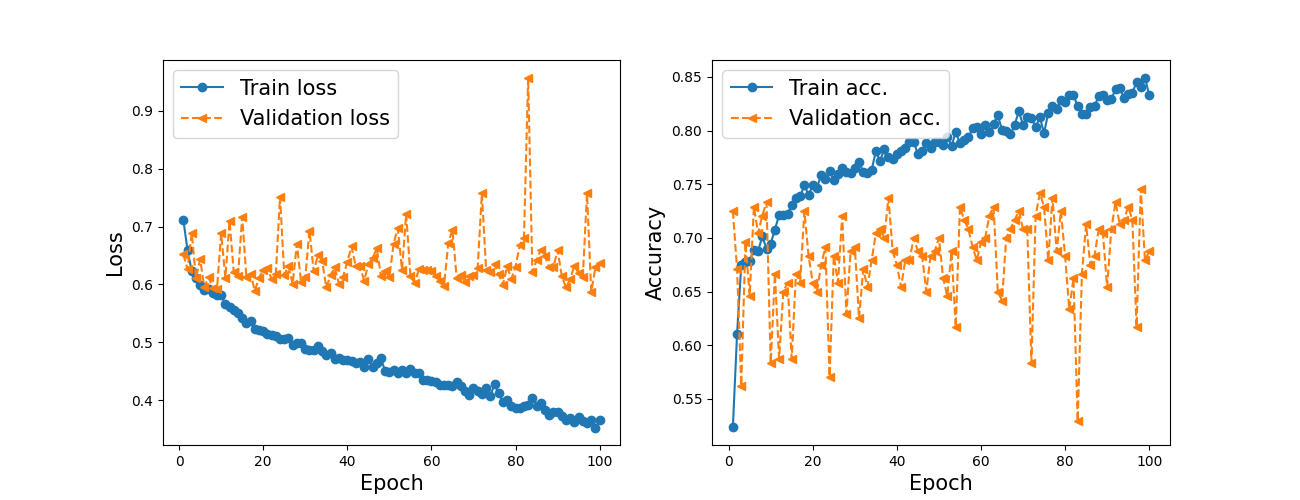

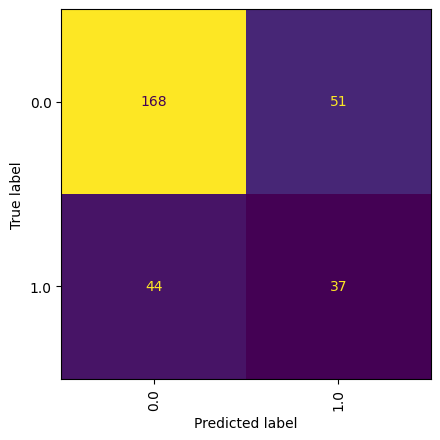

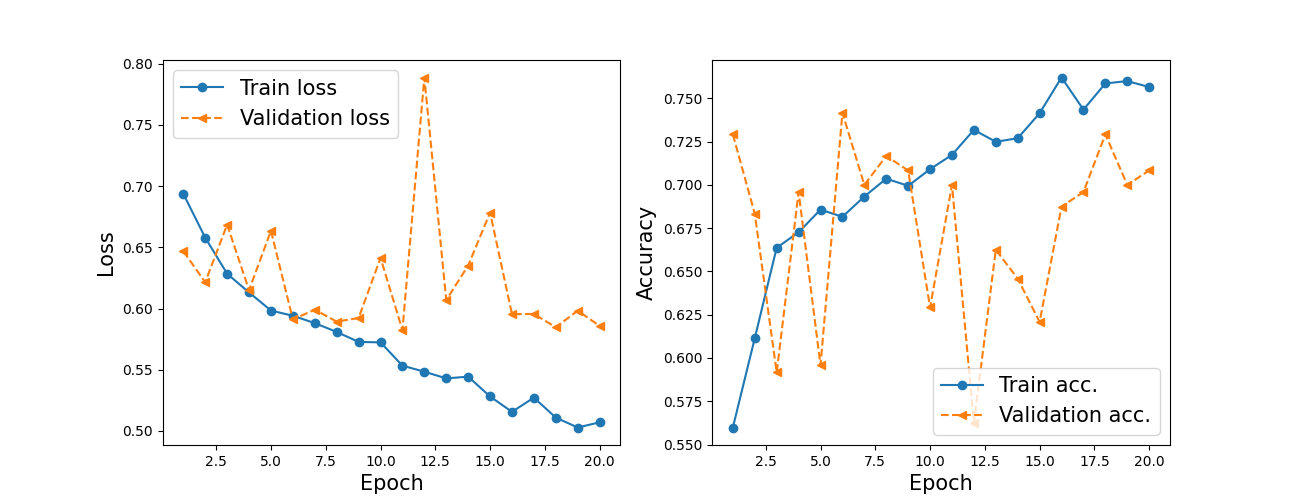

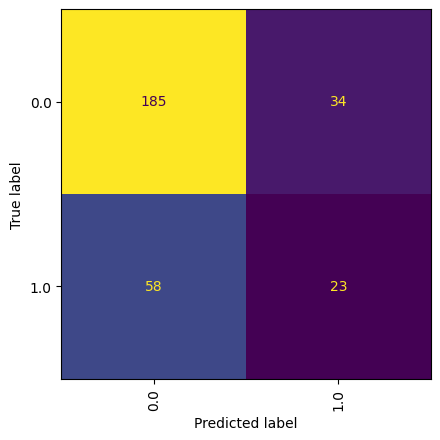

Tabla de datos sin y con Data augmentation para el modelo original con N=1024 conexiones en la ultima capa

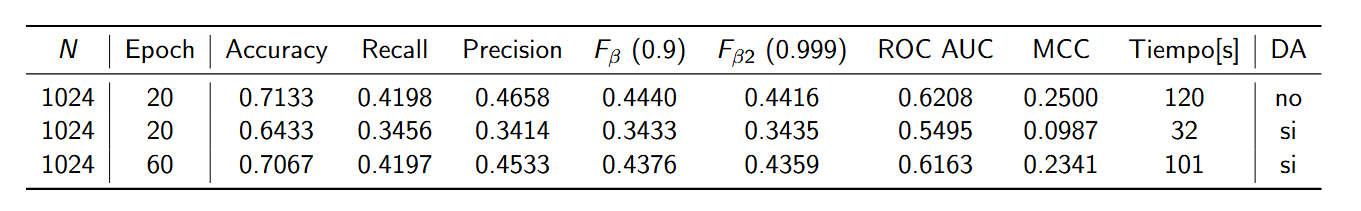

### Acrosoma

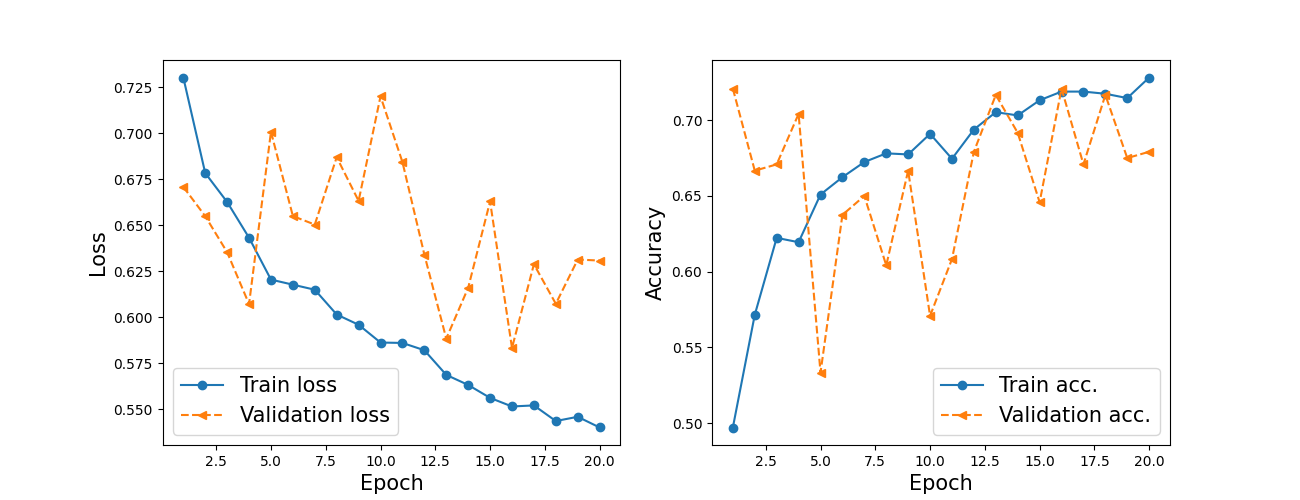

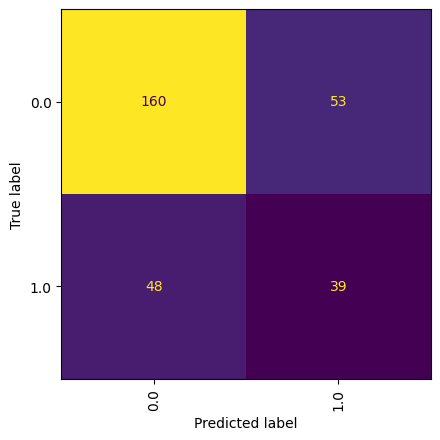

Test accuracy: 0.7100

Metricas

accuracy      ,recall     ,precision     ,fb - b=0.9    ,fb2- b=0.999     ,roc_auc    ,mcc

0.6633333333333333 0.4482758620689655 0.42391304347826086 0.4344802117313966 0.4357420122937656 0.5997247854945766 0.19627136975123355

[[160  53]

 [ 48  39]]


Duración total: 0:00:33.685627



### Vacuola

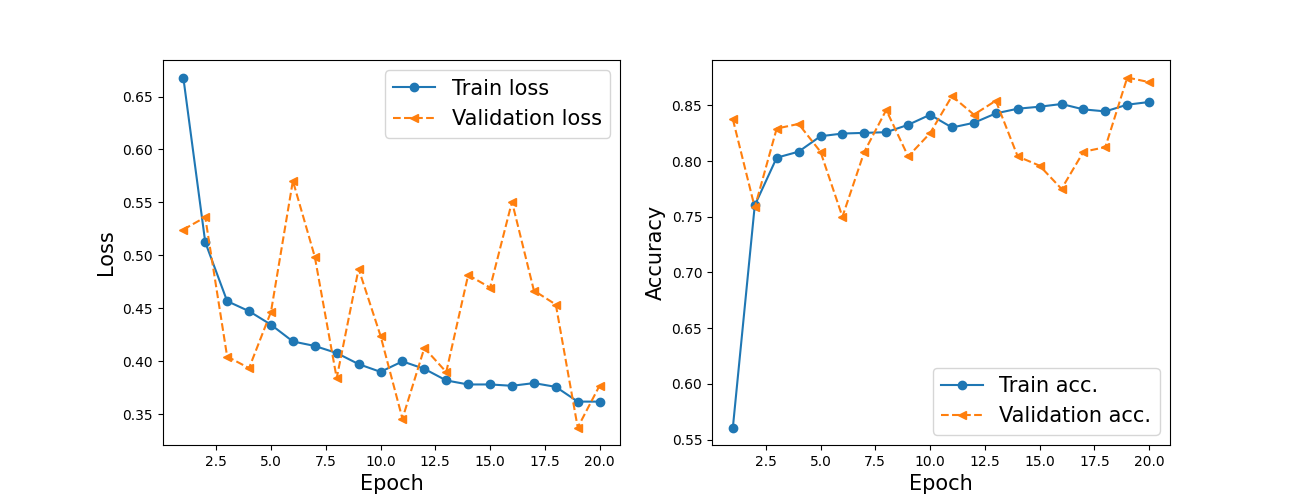

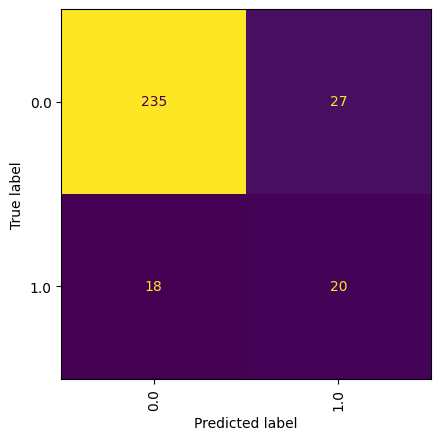

Test accuracy: 0.8733

Metricas

accuracy      ,recall     ,precision     ,fb - b=0.9    ,fb2- b=0.999     ,roc_auc    ,mcc

0.85 0.5263157894736842 0.425531914893617 0.46541527384931863 0.4705383886715326 0.7116311771795901 0.3872958984616711

[[235  27]

 [ 18  20]]